<a href="https://colab.research.google.com/github/mwei19/SNN_nback/blob/main/SNN_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 KB 3.1 MB/s eta 0:00:00


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/SNN_data')

In [2]:
import numpy as np
import torch

def rand_net(A, freeze_diag = True):
    '''Randomize the elements of a 2D tensor.

    Input
    -----
        
    A: tensor
        a 2D tensor (e.g., from PyTorch)
    
    freeze_diag: bool, default=True
        indicating if diagonal values should be randomized (=True) 
        or not (=False).
    
    Output
    ------
        
    X: tensor
        a 2D tensor with randomized values from tensor A
    
    NOTE:
        
    this option is valid only for non-symmetric tensors, that is,
    not every non-zero entry Ai,j corresponds to a non-zero entry Aj,i.
    For symmetric tensors, always freeze_diag=True.
       
    
    Examples:
        
    # if R is symmetric 
    R_rand = rand_net(R)   
        
    # if R is non-symmetric    
    R_rand = rand_net(R, freeze_diag=False)#Randomize also diag
    R_rand = rand_net(R)   
    '''  
    if check_symmetric(A.data.numpy()):
        nodes = A.shape[0]

        # Get the idx and values of the lower diagonal - since A is symmetric,
        # that is all we need.
        X = torch.ones((nodes, nodes)).double() 
        X = torch.triu(X, diagonal=0)
        idx = torch.where(X==0.)
        values = A[idx]

        # Permute values and assign them to lower triangle + diag positions
        values = values[np.random.permutation(len(values))]
        X = torch.zeros((nodes, nodes)).double()  
        X[idx] = values 
        X = X + X.transpose(0,1)# transpose to symmetrize  
        X = X + torch.diagflat(A.diag())
    else: 
        nodes = A.shape[0]
        if freeze_diag:
            # Make mask marking the diagonal with 1s - so we work with the 
            # 0 entries
            M = torch.diagflat(torch.ones(nodes,))
            idx = torch.where(M==0.)
            values = A[idx]
            
            # Permute the values and assign them to a 2D tensor
            values = values[np.random.permutation(len(values))]
            X = torch.zeros((nodes, nodes)).double()  
            X[idx] = values 
            # Put the diagonal valeus to the permuted tensor
            X = X + torch.diagflat(A.diag())
        else:
            # Get the idx of each position in the tensor
            idx = torch.where(A)
            values = A[idx]
            
            # Permute the values and assign them to a 2D tensor
            values = values[np.random.permutation(len(values))]
            X = torch.zeros((nodes, nodes)).double()  
            X[idx] = values
    
    return X

def check_symmetric(X):
    ''' Check is a 2D numpy array is symmetric: if A[i,j] !=0 then A[j,i] !=0   
    for every i,j.
    Thus, no weights are taken into account to decide if symmetry exists.
    
    Input:
    X: numpy array, 2D
    
    Output:
    Boolean denoting if the numpy array is symmetric    
    '''
    return np.all(X == X.T)

In [3]:
import os
import itertools
import numpy as np
import re

from scipy.stats import spearmanr
import torch

# import networkmetrics

def group_shuffle(X, Y, indexes):
    '''Shuffle the rows of X and Y by keeping row with the same index grouped
    
    Input
    -----
    X: ndarray of shape (M,N) 
    
    Y: ndarray of shape (M,K)
    
    indexes: ndarray of shape (M,) of int that group rows. E.g., rows with 
        1 in the indexes array are the same contigouus group of observations
        to be kept together durign shuffling.
    
    Output
    ------
    X: The shuffled X
    
    Y: The shuffled Y
    
    indexes: The shuffled indexes    
    '''
    unique_indexes = np.unique(indexes)
    unique_indexes = unique_indexes[np.random.permutation(len(unique_indexes))]
    rearrange_idx = None
    for i in range(0, len(unique_indexes)):
        idx = np.where(unique_indexes[i] == indexes)[0]
        if rearrange_idx is None:
            rearrange_idx = idx
        else:
            rearrange_idx = np.hstack((rearrange_idx, idx))
        
    X = X[rearrange_idx, :]
    Y = Y[rearrange_idx, :] 
    indexes = indexes[rearrange_idx]
    
    return X, Y, indexes
        
def combo_params(params):
    '''Create a list with tuples denoting all possible combos of values to run
    the model with. Parameters are specified in the dictionary params
    
    Input
    -----
    params: dict, specifying the names and values of the parameters. 
        Values of the dict are lists of the params (a list of str, int, float)
        
    Output
    ------
    all_combos: list of tuples, each tuple corresponding to one unique
        combination of the values of the dict params.
        
    all_keys: list of str, denoting the names of the parameters and the 
        position that they occupy in each tuple in all_combos.
        For instance, parameter values in all_combos[0][0] correspond to param
        with name all_keys[0]
    '''
    all_values = []
    all_keys = []
    # assemble the values of the dictionaries in a list 
    for value in params.values():
        all_values.append(value)
        
    # assemble the keys of the dictionaries in a list 
    for keys in params.keys():                                                 
        all_keys.append(keys)
                 
    all_combos = list(itertools.product(*all_values))
    
    return all_combos, all_keys
           
def map_weights_to_template(w_template = None, w_to_map = None):
    '''Reorder the values of w_to_map in such a way that the valeus obey the 
    rank ordering of the values in w_template.
    The result is X so that: 
        rank order of X[i,j] == rank order of w_template[i,j] where 
        i,j in X[i,j] belongs to all non_zeros values in w_to_map 
     
    Input
    -----
    w_template: torch.Tensor tensor of size (N,M) specifying the rank order 
        of values to be used as reference for reordering the valeus of the 
        w_to_map tensor.
    
    w_to_map: torch.Tensor tensor of size (N,M) containing the values to be 
        reordered so that their rank ordering matches the rank ordering of the
        corresponding values of w_template.
        
    Output
    ------
    X: torch.Tensor tensor of size (N,M) with the reordered values of w_to_map
        such that:
            rank order of X[i,j] == rank order of w_template[i,j] where 
            i,j in X[i,j] belongs to all non_zeros values in w_to_map 
    '''
    X = torch.zeros(w_template.shape)
    idx = torch.where(w_template!=0)
    w_template_values = w_template[idx]
    w_to_map_values = w_to_map[idx]
    
    (sorted_w_template, 
    sorted_index_w_template) = torch.sort(w_template_values, 
                                          dim = 0, 
                                          descending=True)
    
    (sorted_w_to_map, 
     sorted_index_w_to_map) = torch.sort(w_to_map_values, 
                                         dim = 0, 
                                         descending=True)
        
    X[idx[0][sorted_index_w_template], 
      idx[1][sorted_index_w_template]] = sorted_w_to_map                                               
                                                   
    return X   

# Auxiliary function to get the desired parameters from the model
# model: the model from which we should fetch parameters 
# params_to_get: a list of str specifying the names of the params to be fetched     
def get_model_params(model, params_to_get = None):
    '''Extracts the parameters, names, and 'requires gradient' status from a 
    model.
    
    Input
    -----
    model: class instance based on the base class torch.nn.Module
    
    params_to_get: list of str, default=None, specifying the names of the 
        parameters to be extracted.
        If None, then all parameters and names of parameters from the model 
        will be extracted
    
    Output
    ------     
    params_name:, list, contaning one str for each extracted parameter
    
    params_values: list, containg one tensor corresponding to each 
        parameter. NOTE: The tensor is detached from the computation graph 
    req_grad_orig: list, containing one Boolean variable for each parameter
        denoting the requires_grad status of the original tensor/parameter 
        of the model     
    '''    
    params_names = []
    params_values = [] 
    req_grad_orig = []
    for name, param in zip(model.named_parameters(), model.parameters()):             
        if params_to_get is not None:
            if name[0] in params_to_get: 
                params_names.append(name[0])
                params_values.append(param.detach().clone())
                req_grad_orig.append(param.requires_grad)
        else:
            params_names.append(name[0])
            params_values.append(param.detach().clone())
            req_grad_orig.append(param.requires_grad)
                       
    return params_values, params_names, req_grad_orig

# Freeze (update=False) or unfreeze (update=True) model params
def freeze_params(model, 
                  params_to_freeze = None,
                  update = True):  
    '''Freeze or unfreeze the parametrs of a model
    
    Input
    -----
    model:  class instance based on the base class torch.nn.Module
    
    params_to_freeze: list of str specifying the names of the params to be 
        frozen or unfrozen
        
    update: bool, default True, specifying the freeze (update=False) or 
        unfreeze (update=True) of model params 
        
    Output
    ------
    model: class instance based on the base class torch.nn.Module with changed
        requires_grad param for the anmes params in params_to_freeze
        (freeze = requires_grad is False unfreeze = requires_grad is True)   
    '''
    for name, param in zip(model.named_parameters(), model.parameters()):             
        if params_to_freeze is not None:
            if name[0] in params_to_freeze: 
                param.requires_grad = update 
        else:
            param.requires_grad = update 
    
    return model

def calc_accuracy(output = None, labels = None):
    '''Classification accuracy calculation as acc = (TP + TN) / nr total pred
    
    Input
    -----
    output: torch.Tensor tensor of size (N,M) where N are the observations and 
        M the classes. Values must be such that highest values denote the 
        most probable class prediction.
    
    labels: torch.Tensor tensor of size (N,) of int denoting for each of the N
        observations the class that it belongs to, thus int must be in the 
        range 0 to M-1
    
    Output
    ------
    acc: float, accuracy of the predictions    
    '''
    _ , predicted = torch.max(output.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    acc = 100*(correct/total)

    return acc

def save_model_state(model, 
                     epoch = None, 
                     iteration = None,
                     folder_name = None):
       '''Save the model's state dict
       
       Input
       -----
       model: class instance based on the base class torch.nn.Module
       
       epoch: positive int, denoting the training epoch in which the model to 
           be saved is in
       
       iteration: positive int, denoting the iteration in which the model to be 
           saved is in. Iteration is 1 complete training cycle of the model
           across N epochs.
           NOTE: This should not be confused with the number of times a batch 
           of data passed through the algorithm (also called iteration).
       
       folder_name: object of class pathlib.PosixPath
           The folder in which the model state dict will be stored 
       '''
       file_name = 'model_state_dict' + '_epoch_' + str(epoch) + '_iter_' + str(iteration) + '.pth'
       file_to_save = folder_name / file_name
       torch.save(model.state_dict(), file_to_save)   
       
# Load pretrained model
def load_pretrained(model,
                    pretrained_folder = None, 
                    epoch = 0,
                    it = 0,
                    combo_nr = 0):
    '''Load the model's state dict
       
    Input
    -----
    model: class instance based on the base class torch.nn.Module
    
    pretrained_folder: object of class pathlib.PosixPath
        The folder in which the model state dict will be stored 
           
    epoch: positive int, denoting the training epoch in which the model to 
        be saved is in
       
    it: positive int, denoting the iteration in which the model to be 
        saved is in. Iteration is 1 complete training cycle of the model
        across N epochs.
        NOTE: This should not be confused with the number of times a batch 
        of data passed through the algorithm (also called iteration).
    
    combo_nr: positive int, denoting the nr of the parameter combination
        that corresponds to the trained stored model. 
        The int value can be arbitrary with the only constrained that it is 
        unique, that is, each int denotes one stored model trained 
        with a unique combination of parameters.
        
    Output
    ------
    model: class instance based on the base class torch.nn.Module with the 
        stored state dict      
    '''    
    file_name = 'model_state_dict_epoch_' + str(epoch) + '_iter_' + str(it) + '.pth'
    file_to_open = pretrained_folder / str(combo_nr) / file_name
    
    model.load_state_dict(torch.load(file_to_open))    
    
    return model           
       
# Scale tensor to [0 1] by takin into account the global min and max
def scale_tensor(X, global_scaling = True, epsilon = 1e-12):
    '''Scale tensor to [0 1] by takin into account the global min and max 
    (global_scaling=True) or the row-wise min max (global_scaling=False)
    
    Input
    -----
    X : torch.Tensor tensor os size (N,M), the tensor to be rescaled to [0 1]
        
    global_scaling: bool, default True
        Boolean variable specifying if the scaling should be performed by 
        taking into account the global min and max values (default)
        
    epsilon: float (default: 1e-12) 
        A small number to avoid potential divisions with 0  
        
    Output
    ------
    X_norm: torch.Tensor tensor os size (N,M) which is the rescaled tensor X   
    '''
    if global_scaling is True:
        min_val = torch.min(X)
        max_val = torch.max(X)
        denom = torch.clamp(max_val-min_val, min = 2*epsilon)
        nom = X-min_val
        X_norm = torch.div(nom+epsilon, denom)
    else:
        min_val = torch.min(X, dim=1)[0]
        max_val = torch.max(X, dim=1)[0]
        denom = torch.clamp(max_val-min_val, min = 2*epsilon)
        nom = X.T-min_val
        nom = nom.T + epsilon
        X_norm = torch.div(nom.T, denom)
        X_norm = X_norm.T
        
    return X_norm   

def concatenate_arrays(master_container = None, 
                       leech = None, 
                       mode = 'h'):
    '''Concatenate ndarrays vertically or horizontally
    
    Input
    -----
    master_container: ndarray, of shape (M,N), default None, that each time 
        changes from a concatanation with leech. When None, then the leech will
        become the master_container
        
    leech: ndarray, of shape (K,L) that will be concatenated to 
        master_container. The shape (K,L) must match to the shape (M,N) 
        dependong on whether the mode of concatenation is horizontal or 
        vertical. See np.hstack and np.vstack documentation. 
            
    mode: str, default 'h', specifying if the concatenation is horizontal ('h') 
        or vertical ('v').
    
    Output
    ------
    master_container: ndarray of shape (M,N+L) if mode='h' or (M+K,N) if 
        mode='v'.
        
    '''
    if master_container is not None:
        if mode == 'h':
            master_container = np.hstack((master_container, leech))
        if mode == 'v':
            master_container = np.vstack((master_container, leech))
    else:
        master_container = leech  
        
    return master_container  

def calculate_metrics(model,
                      file_to_model = None, 
                      metrics = [],
                      params_to_get = None):
    '''Compute network metrics on a specified layer of a given PyTorch model that 
    is stored.
    
    Input
    -----
    model: a class instance based on the base class torch.nn.Module. The 
        model must contain at least a recurrent layer (to be named explicitly
        in params_to_get)
        
    file_to_model: object of class pathlib.PosixPath specifying the full path
        to the stored model
    metrics: list of str, default [], with the metrics to be computed on each 
        reccurent layer.
        Currently to options:
            'hi': homophily index
            'sil': silhouette specifyign the clusterness of the recurrent
                mlayer as specified by kmeans
    params_to_get: str specifying the name of the reccurent layer to use
        for computing the metrics.
        
    Output
    ------
    all_metrics: a list containing the metrics    
    '''
    all_metrics = []# store all the computed metrics in a list
    
    # Load pretrained model
    model.load_state_dict(torch.load(file_to_model))
    values, names = get_model_params(model,
                                     params_to_get=params_to_get)#select what matrix of the model needs analysis
    w = values[0]#this is the matrix that we have to work with
    
    if 'hi' in metrics:
        print('Computing homophily...')
        hi = calc_homophily(w.data.numpy())
        all_metrics.append(hi)
    
    if 'sil' in metrics:
        print('Computing silhouette...')
        scores, labels = get_clusters(
                                                      w.data.numpy(), 
                                                      nr_cluster=[2, 3, 4, 5], 
                                                      metric='euclidean'
                                                      )
        all_metrics.append(scores)        
    
    return all_metrics

# Get the min loss
def min_loss(losses):
    '''Find min value in each row of ndarray losses
    
    Input
    -----
    losses: ndarray of shape (M,N) 
    
    Output
    ------
    all_losses: list containing the min value of each row of losses
    '''
    all_losses = []
    for i in range(losses.shape[0]):
        all_losses.append(np.min(losses[i, :]))
    
    return all_losses 
   
def min_loss_epoch(losses, perc = None):
    '''Get the index of min value for each row in losses.
    
    If a perc is specified, then the index of the min value in each row
    satisfies the following:
    ((losses-np.min(losses))/(np.max(losses)-np.min(losses)))*100 <= 100-perc
    
    Input
    -----
    losses: ndarray of shape (M,N)
    
    perc:  int 0 < perc < 100   

    Output
    ------
    all_min_loss_ep: list with an idx for each row denoting where the 
        min value was observed (taking into account the perc params or not)        
    
    '''
    all_min_loss_ep = [] 
    if perc is not None: perc = 100-perc      
    for i in range(losses.shape[0]):
            if perc is None:
                value = np.min(losses[i, :])
                all_min_loss_ep.append(
                                       np.where(value == losses[i, :])[0][0]#get the integer value of the index/epoch
                                       )                
            else:
                val_perc = ((losses[i, :]-np.min(losses[i, :]))/(np.max(losses[i, :])-np.min(losses[i, :])))*100
                idx = np.where(val_perc <= perc)[0]
                all_min_loss_ep.append(np.min(idx))
                
    return all_min_loss_ep    

def reshape_to_vector(x):
    '''Reshape an ndarray x
    
    Input
    -----
    x: ndarray of shape (M,N)
    
    Output
    ------
    x_reshaped: the reshaped x ndarray
    
    see np.reshape documentation  
    '''
    x_reshaped =np.reshape(x, 
                          (x.size), 
                           'C')

    return x_reshaped 

# Read the results and extract desired quantiities
def read_results(results_folder = None, 
                 results_id = None,
                 start = None,
                 stop = None):
    #Dict to store all raw results
    raw_results = {}
    
    #Dict to store all quantities calculated on raw results
    quantities_on_results = {}
    
    # Get metrics/loss
    file_name = 'train_loss_all.npy'
    file_to_open = results_folder / str(results_id) / file_name
    train_loss_all= np.load(file_to_open)
    
    # The shape of the results indicate the epochs and iterations
    iterations = train_loss_all.shape[0]
    total_epochs = train_loss_all.shape[1]
    
    if stop is None:
        stop = total_epochs
    
    file_name = 'validate_loss_all.npy'
    file_to_open = results_folder / str(results_id) / file_name
    validate_loss_all = np.load(file_to_open)

    current_min_loss = min_loss(validate_loss_all[:, start:stop])
    
    # get min epoch for loss only for validation
    current_min_loss_ep = min_loss_epoch(validate_loss_all[:, start:stop], 
                                         perc=None)
    
    # get min epoch for 99% loss only for validation
    current_min_loss_ep_perc = min_loss_epoch(validate_loss_all[:, start:stop], 
                                              perc=99)
    
    # Check if a file corresponding to metrics exists and is not empty
    # (maybe stored empty) and if so, set the boolean value load_metrics to True
    load_metrics = False
    file_name = 'train_metrics_all.npy'
    file_to_open = results_folder / str(results_id) / file_name
    metrics_exists = os.path.exists(file_to_open)
    
    if metrics_exists:
        train_metrics_all = np.load(file_to_open)
        if train_metrics_all.size > 0:
            load_metrics = True
    
    # Get metrics if load_metrics is True
    if load_metrics:
        file_name = 'train_metrics_all.npy'
        file_to_open = results_folder / str(results_id) / file_name
        train_metrics_all = np.load(file_to_open)
        
        file_name = 'validate_metrics_all.npy'
        file_to_open = results_folder / str(results_id) / file_name
        validate_metrics_all = np.load(file_to_open)
        
    #Store results - raw results    
    raw_results = {
                  'train_loss': train_loss_all[:, start:stop],
                  'validate_loss': validate_loss_all[:, start:stop]
                  }
    
    if load_metrics:
        raw_results['train_metrics'] = train_metrics_all[:, start:stop]
        raw_results['validate_metrics'] = validate_metrics_all[:, start:stop]
            
    #Store results - quantities calculated on raw results
    quantities_on_results = {
                            'min_loss': current_min_loss,
                            'min_loss_ep': current_min_loss_ep,
                            'min_loss_ep_perc': current_min_loss_ep_perc
                            }        
    
    ep = range((stop-start))
    
    return raw_results, quantities_on_results, ep, iterations 

def extend_list(list_to_ext = None, ext = None):
    '''Extend a list of lists as follows:
    Construct a new list of lists ext_list such that the first list of 
    ext_list is a list of li[n]*ext where li is the ith list in list_to_ext
    and n is the nth item of list li. The construction of ext_list proceeds
    from n=0..N-1 where N is the length of li.
    
    Hence all lists li in list_to_ext must have the same length. 

    Example:
    a = [['apple','carrot'],['grape','orange']]
    ext_list = extend_list(list_to_ext=a, ext=5)

    ext_list=[
      ['apple',
       'apple',
       'apple',
       'apple',
       'apple',
       'grape',
       'grape',
       'grape',
       'grape',
       'grape'],
      ['carrot',
       'carrot',
       'carrot',
       'carrot',
       'carrot',
       'orange',
       'orange',
       'orange',
       'orange',
       'orange']
      ] 
       
    list_to_ext: a list of lists to be expanded
    
    ext: int, positive, denoting the amount of expansion of each list item
        li[n]*ext
        
    ext_list: the expanded list with the "expanded" structure explained above.    
    '''
    ext_list = []
    for i, combo in enumerate(list_to_ext):
        for c, item in enumerate(combo):
           if i==0:
               ext_list.append([item] * ext)
           else:
               new_item = [item] * ext
               ext_list[c] = ext_list[c] + new_item
    
    return ext_list

# Clean string from special characters
def clean_str(dirty_string):
    '''Clean string from special characters and return a list with the
    clean strings. This is a tailored cleaning that corresponds to a 
    specific input string format.
    
    Example:
    dirty_string= "(0.1, 'sign', 'of course', 4)\n" 
    clean_strings = clean_str(dirty_string)
    clean_strings -> ['0.1', 'sign', 'of course', '4']
    '''
    clean_strings = re.sub("'", "", dirty_string)# remove '   
    clean_strings = clean_strings.replace("(","")# remove parentheses
    clean_strings = clean_strings.replace(")","")
    clean_strings = clean_strings.split(',')# split strings
    clean_strings = [i.strip() for i in clean_strings]# remove whitespaces
    
    return clean_strings

def get_activation_model(model, 
                         data_generator = None, 
                         device = 'cpu'): 
    '''Obtain the activations of the last hidden layer of an Elman RNN.
    
    Input
    -----
    model: an RNN model, an instance of class nn.Module
    data_generator: data generator, torch.utils.data.dataloader.DataLoader,
        that feeds the model data to get the  activations 
    device: str, specifying the device used for performing the forward pass
        'cpu' or 'gpu'
        
    Output
    ------
    all_hidden: list of tensors, len N, of shape (B,T,H)
        N depends on the batch size (data generator parameter) and the 
        number of data
        B is the batch size, T the time dimension of the data and H are the 
        nr of hidden units of the reccurent networks.
        NOTE that (B,T,H) corresponds to batch_first is True
        otheriwise the shape of the tensors is (T,B,H)
    '''        
    all_hidden = []
    # Make sure that the model is not at the training mode
    model.train(False)
    for X_batch, Y_batch in data_generator:
        # Send tensors to the device used
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device) 
        output, hidden = model(X_batch)
        # Output is hidden state for eact timepoint - that is what we need
        # to keep in a list
        all_hidden.append(output.data)
                
    return all_hidden

def compute_coactivation(batch_time_activations):
    '''Compute coactivations based on activity in the ndarrray 
    batch_time_activations  
    
    Input
    -----
    batch_time_activations: ndarray of shape (B,T,H) with: 
        B the batch size
        T the nr of time steps
        H the activations
        
    Output
    ------
    coactivations: ndarray of shape (B,H,H) 
        this is the coactivation matrix (H,H) for each datapoint in the batch
        
    '''
    all_coact_np = np.zeros((batch_time_activations.shape[0],
                             batch_time_activations.shape[2],
                             batch_time_activations.shape[2])
                            )
    for item in range(batch_time_activations.shape[0]): 
        res = spearmanr(batch_time_activations[item])
        current_coact = res[0]
        all_coact_np[item,:,:] = current_coact 
    
    return all_coact_np

def get_mean_coactivation(all_hidden):
    '''Compute mean coactivations based on activity in the list of tensors 
    all_hidden  
    
    Input
    -----
    all_hidden: list of len N containing tensors of shape (B,T,H) with: 
        B the batch size
        T the nr of time steps
        H the activations
        
    Output
    ------
    mean_coactivations: ndarray of shape (H,H) 
        this is the mean coactivation matrix (H,H) across N datapoint in the 
        batch
    
    '''
    all_coactivations = None
    for hidden in all_hidden:
        coact = compute_coactivation(hidden.data.numpy())   
        mean_coact = np.mean(coact, axis=0)
        idx = np.where(~np.eye(mean_coact.shape[0], dtype=bool))#get all but the diagonal elements
        coactivations = mean_coact[idx]
        all_coactivations = concatenate_arrays(master_container=all_coactivations,
                                               leech=coactivations,
                                               mode='v')
    mean_coactivations = np.mean(all_coactivations, axis=0)
    
    return mean_coactivations 

In [4]:
import numpy as np
import random

from sklearn.model_selection import GroupShuffleSplit
import torch
from torch.utils import data

# import auxfun

# Dataset class
class Dataset(data.Dataset):
  '''
  Map-style dataset object to be used from the DataLoader
  It implements the __get_item()__ and __len()__ methods
  See https://pytorch.org/docs/stable/data.html
  '''
  def __init__(self, trials_in, trials_out, trial_ids):
        # Initialize
        self.trials_in = trials_in
        self.trials_out = trials_out
        self.trial_ids = trial_ids
        unique_trial_ids = np.unique(trial_ids)# get the unique ids
        #permute to ensure mixed labels/trials in the batch and assign to object!!!
        self.unique_trial_ids = unique_trial_ids[np.random.permutation(len(unique_trial_ids))]

  def __len__(self):
        # Size of unique trials
        return len(self.unique_trial_ids)

  def __getitem__(self, index):
        # Generates one trial
        # Select sample
        current_id = self.unique_trial_ids[index]
        idx = np.where(current_id == self.trial_ids)[0]            
        # Load data and get label
        X = self.trials_in[idx, :]
        Y = self.trials_out[idx, :]

        return X, Y

# Task functions 
def generate_sequence_patterns(
                               pattern_length = 3, 
                               low = 0., 
                               high = 1., 
                               nr_of_trials = 100
                               ): 
    '''
    Generate pattern to memorize with length N and from a uniform distribution
    between low and high values. 
    
    Trials have a memorize period (the generated numbers=pattern_length) 
    and a recall period, that is, 0s=pattern_length. The trials are padded with
    zeros and ones with 1 denoting "recall cue". Thus, trials are 2D arrays. 
    
    Input
    -----
    pattern_length: int, default 3, indicating the lenght of the pattern to
        be memorized
        
    low: float, default 0., corresponding to the lowest value of the uniform
        distribution from which random numbers are drawn
        
    high: float, default 1., corresponding to the highest value of the uniform
        distribution from which random numbers are drawn    
        
    nr_of_trials: int, default 100, indicating the total number of trials
    
    Output
    ------
    all_input_trials: ndarray of shape (N,2) where:
        N = ((pattern_length*2) + 1) * nr_of_trials
        
    all_output_trials: ndarray of shape (N,1) where:
        N = ((pattern_length*2) + 1) * nr_of_trials
        
    all_trials_index: ndarray of shape (N,) where:
        N = ((pattern_length*2) + 1) * nr_of_trials 
    '''
    all_input_trials = None
    all_output_trials = None
    all_trials_index = None
    for tr in range(nr_of_trials):
        # Create here standard blocks of the trials, namely the cue and "null input"
        # The cue is a 1 on a channel that is not used for the patterns,
        # so concatanate a vector with 0s when we have a trial with input 
        # (the patterns to be memorized) and a 1 to denote the recall cue
        # when the reservoir has to replay the patterns. 
        
        # 1 is presented only once, with zeros following it for the "null input"   
        null_input = np.zeros((2, pattern_length+1), dtype='float32')
        
        # Assign the cue at the upper left corner so that the first column of the 
        # null input is actually the recall cue.
        null_input[0,0] = 1
        padding_for_trial = np.zeros((pattern_length,), dtype='float32')
        
        #Generate one trial based on the specifications
        trial = np.random.uniform(low, high, pattern_length)
        trial = trial.astype('float32')
    
        # Add the padding that corresponds to a cue=0 (that means no replaying yet,
        # but leanrning the input patterns)
        trial = np.vstack((padding_for_trial, trial))
        input_trial = np.hstack((trial, null_input))
        
        # Now we can construct the desired ouput. This is basically a "mirrored"
        # version of the input, so construct accordingly: where null_input put
        # the current trial and vice versa. 
        
        # We need no padding for the output (no "cue needed"). Just require 0s
        # when the pattern is being learned.
        null_output = np.zeros((1, pattern_length+1), dtype='float32')#Add 1 column to have the same length with input
        trial = trial[1:,:]   
        output_trial = np.hstack((null_output, trial))
        
        # Concatanate the generated input/output trials to the the overall 
        # trials array 
        if all_input_trials is None:            
            all_input_trials = input_trial
            all_output_trials = output_trial            
        else:            
            all_input_trials = np.hstack((all_input_trials, input_trial))
            all_output_trials = np.hstack((all_output_trials, output_trial))
            
        # Construct the indexes to keep track of the trials
        current_index = np.zeros(input_trial.shape[1], dtype='float32')
        current_index[:] = tr
               
        if all_trials_index is None:            
            all_trials_index = current_index            
        else:            
            all_trials_index = np.hstack((all_trials_index, current_index))
            
    all_input_trials = all_input_trials.T
    all_output_trials = all_output_trials.T
    all_trials_index = all_trials_index.T
        
    return all_input_trials, all_output_trials, all_trials_index   

def generate_pic_wm_trials(
                           images = None,
                           trial_length = 5, 
                           nr_of_trials = 100, 
                           n_back = None,
                           trial_matching = False,
                           rescale = True
                           ): 
    '''
    Generate trials of a N-Back working memory task based on 2D images
    
    The trials consists of consecutive images and the task is to decide
    if the image presented last matches or not (in terms of category e.g. 
    number) the image N timesteps ago
    
    The trials are padded with zeros and ones with 1 denoting "target image" 
    cue. Thus, trials are 2D arrays
    
    Input
    -----
    images: ndarray of shape (N,K,L) with N the number of images, and K and L
        the dimensions of the image
        
        images contain values in the [0 255] range
        
        As a default the MNIST dataset, asprepackaged in Keras, is used.
        Thus, N=10000 K=28 L=28 and datatype is unit8
        
        However, any image dataset can be passed as an argument given that it
        complies with the aformentioned format

    trial_length: int, default 5, indicating the lenght of the trial, 
        specifically the number of images that are used in the memorization 
        phase of the task. The image corresponding to the latest timestep is 
        always the target image. For instance if trial_length=5, them the 5th
        image is the target
     
    nr_of_trials: int, default 100, indicating the total number of trials    
    
    n_back: int specifying the match N timesteps before the last image. For
        instance, if n_back=2, then the image that should be compared with the 
        target image is the 3rd image in the trial
        
    trial_matching: bool, default False, specifying if the trials to be 
        generated should be matching trials(=True) or non-matching trials 
        (=False) 
        
    rescale: bool, default True, specifying if the images should be rescaled
        by dividing with 255
        
    Output
    ------
    all_input_trials: ndarray of shape (N,M) where:
        N = ((trial_length*2) + 1) * nr_of_trials
        M = (K*L)+1 (image size + 1)
        
    all_output_trials: ndarray of shape (N,1) where:
        N = ((trial_length*2) + 1) * nr_of_trials
        
    all_trials_index: ndarray of shape (N,) where:
        N = ((trial_length*2) + 1) * nr_of_trials        
    '''
    if ((trial_length-n_back) <=0) and (n_back is not None):
        raise ValueError('N-Back value must be less than the trial length')
           
    all_input_trials = None
    all_output_trials = None
    all_trials_index = None
        
    img_pixels = images.shape[1]*images.shape[2] 
    
    for tr in range(nr_of_trials):
        # Create here standard blocks of the trials, namely the cue and "null input"
        # The cue is a 1 on a channel that is not used for the patterns,
        # so concatanate a vector with 0s when we have a trial with input 
        # (the patterns to be memomorized) and a 1 to denote the recall cue
        # when the reservoir has to replay the patterns. 
        
        # 1 is presented only once, with zeros following it for the "null input" 
        null_input = np.zeros((img_pixels+1, 2))
        
        # Assign the cue at the upper left corner so that the first column of the 
        # null input is actually the recall cue.
        null_input[0,0] = 1
        
        padding_for_trial = np.zeros((trial_length,))
        
        #Generate one trial based on the specifications
        # The last pic in the trial must be also the pic n_back steps
        target_pic_idx = random.randrange(images.shape[0])
        trial = np.zeros((img_pixels, trial_length))
        
        #Mark the positions of the target picture with 1s and assign the 
        #target pic in the correct indexes indicated by len(trial_idxs) and
        #n_back. Take into account if the trials are 
        #trial_matching = True or False
        trial_idxs = np.zeros((trial_length,))
        
        if trial_matching is True:
            trial_idxs[len(trial_idxs)-1] = 1
            trial_idxs[(len(trial_idxs)-1) - n_back] = 1
            trial[:, len(trial_idxs)-1] =  images[target_pic_idx, :, :].reshape(img_pixels,)
            trial[:, (len(trial_idxs)-1) - n_back] =  images[target_pic_idx, :, :].reshape(img_pixels,)
        else:
            trial_idxs[len(trial_idxs)-1] = 1
            trial[:, len(trial_idxs)-1] =  images[target_pic_idx, :, :].reshape(img_pixels,) 
        
        random_pic_idx = random.sample(range(0, images.shape[0]-1), 
                                       len(np.where(trial_idxs == 0)[0]))
    
        rand_pic_idxs = np.where(trial_idxs == 0)[0]
    
        for i in range (len(random_pic_idx)):
           trial[:,rand_pic_idxs[i]] = images[random_pic_idx[i], :, :].reshape(img_pixels,)
    
        #Rescale to 255 if rescale True
        if rescale is True:
            trial = trial/255
    
        # Add the padding that corresponds to a cue=0 
        #(that means no replaying yet, but learning the input patterns)
        trial = np.vstack((padding_for_trial, trial))
        
        input_trial = np.hstack((trial, null_input))
        
        # Now we can construct the desired ouput. 
        # What we need is an array with input_trial shape with 3 discrete
        # values: 
        # 0:fixation 
        # 1:n_back matches=False
        # 2:n_back matches=True
        # Hence, the output trials correspond to the correct labels of 
        # a 3-class classification problem
        output_trial = np.zeros((1, trial_length+2))#Add 1 column to have the same length with input
        
        #Assign the correct labeling
        
        if trial_matching is True:
            output_trial[0, (trial_length+1):] = 2
        else:
            output_trial[0, (trial_length+1):] = 1
        
        # Concatanate the generated input/output trials to the overall 
        # trials array 
        if all_input_trials is None:       
            all_input_trials = input_trial
            all_output_trials = output_trial       
        else:       
            all_input_trials = np.hstack((all_input_trials, input_trial))
            all_output_trials = np.hstack((all_output_trials, output_trial))
            
        # Construct the indexes to keep track of the trials
        current_index = np.zeros(input_trial.shape[1],)
        current_index[:] = tr
        
        
        if all_trials_index is None:          
            all_trials_index = current_index          
        else:          
            all_trials_index = np.hstack((all_trials_index, current_index))
            
    all_input_trials = all_input_trials.T
    all_output_trials = all_output_trials.T
    
    all_trials_index = all_trials_index.T
          
    return all_input_trials, all_output_trials, all_trials_index  

def generate_pic_latent_wm_trials( 
                                  images = None,
                                  labels = None,
                                  trial_length = 5, 
                                  nr_of_trials = 100, 
                                  n_back = None,
                                  trial_matching = False,
                                  rescale = True
                                  ): 
    '''
    Generate trials of a N-Back working memory task based on 2D images that 
    are first fed into a CONVNET.
    
    The trials consists of consecutive images and the task is to decide
    if the image presented last matches or not (in terms of category e.g. 
    number) the image N timesteps ago
    
    The trials are padded with zeros and ones with 1 denoting "target image" 
    cue. Thus, trials are 2D arrays
    
    Input
    -----
    images: torch.Tensor of shape (N,K) with N the number of images, and K
        the dimensions of the image in the latent space of the CNVNET
                
    trial_length: int, default 5, indicating the lenght of the trial, 
        specifically the number of images that are used in the memorization 
        phase of the task. The image corresponding to the latest timestep is 
        always the target image. For instance if trial_length=5, them the 5th
        image is the target
     
    nr_of_trials: int, default 100, indicating the total number of trials    
    
    n_back: int specifying the match N timesteps before the last image. For
        instance, if n_back=2, then the image that should be compared with the 
        target image is the 3rd image in the trial
        
    trial_matching: bool, default False, specifying if the trials to be 
        generated should be matching trials(=True) or non-matching trials 
        (=False) 
        
    rescale: bool, default True, specifying if the images should be rescaled
        to the [0 1] range
        
    Output
    ------
    all_input_trials: ndarray of shape (N,M) where:
        N = ((trial_length*2) + 1) * nr_of_trials
        M = (K+1 (latent space size + 1)
        
    all_output_trials: ndarray of shape (N,1) where:
        N = ((trial_length*2) + 1) * nr_of_trials
        
    all_trials_index: ndarray of shape (N,) where:
        N = ((trial_length*2) + 1) * nr_of_trials    
    
    '''
    if ((trial_length-n_back) <=0) and (n_back is not None):
        raise ValueError('N-Back value must be less than the trial length')
           
    all_input_trials = None
    all_output_trials = None
    all_trials_index = None
        
    img_size = images.shape[1]
    #Rescale to [0 1] if rescale True
    if rescale is True:
        images = scale_tensor(images, 
                                     global_scaling = False
                                     )# rescale each trial seperately (row-wise rescaling)
    
    # Convert to numpy
    images = images.clone().numpy()
    labels = labels.clone().numpy()

    # Keep unique labels
    unique_labels = np.unique(labels)    
    for tr in range(nr_of_trials):
        # Create here standard blocks of the trials, namely the cue and "null input"
        # The cue is a 1 on a channel that is not used for the patterns,
        # so concatanate a vector with 0s when we have a trial with input 
        # (the patterns to be memomorized) and a 1 to denote the recall cue
        # when the reservoir has to replay the patterns. 
        
        # 1 is presented only once, with zeros following it for the "null input" 
        null_input = np.zeros((img_size+1, 2), dtype = 'float32')
        
        # Assign the cue at the upper left corner so that the first column of the 
        # null input is actually the recall cue.
        null_input[0,0] = 1
        
        padding_for_trial = np.zeros((trial_length,), dtype = 'float32')
        
        # Generate one trial based on the specifications
        # The last pic in the trial must be also the pic n_back steps
        # Select the targets and the non-targets based on the labels
        target_pic_label = random.randrange(unique_labels.shape[0])
        trial = np.zeros((img_size, trial_length), dtype = 'float32')
        
        potential_target_pic_idxs = np.where(target_pic_label == labels)[0]
        potential_non_target_pic_idxs = np.where(target_pic_label != labels)[0]
        
        target_pic_idx = random.sample(list(potential_target_pic_idxs), 1)
        target_pic = images[target_pic_idx, :]
        
        # Remove the index of the used pic from the pool of potential targets
        potential_target_pic_idxs = potential_target_pic_idxs[np.where(
                                                              potential_target_pic_idxs != target_pic_idx
                                                              )[0]
                                                             ]
        
        #Mark the positions of the target picture with 1s and assign the 
        #target pic in the correct indexes indicated by len(trial_idxs) and
        #n_back. Take into account if the trials are 
        #trial_matching = True or False
        trial_idxs = np.zeros((trial_length,), dtype = 'float32')
        
        if trial_matching is True:
            trial_idxs[len(trial_idxs)-1] = 1
            trial_idxs[(len(trial_idxs)-1) - n_back] = 1
            trial[:, len(trial_idxs)-1] = target_pic
            trial[:, (len(trial_idxs)-1) - n_back] = target_pic
        else:
            trial_idxs[len(trial_idxs)-1] = 1
            trial[:, len(trial_idxs)-1] = target_pic
        
        rand_pic_in_trial_idxs = np.where(trial_idxs == 0)[0]
        
        random_pic_idx = random.sample(list(potential_non_target_pic_idxs), 
                                       len(rand_pic_in_trial_idxs)
                                       )
  
        for i in range (len(random_pic_idx)):
           trial[:, rand_pic_in_trial_idxs[i]] = images[random_pic_idx[i], :]
     
        # Remove from the pool of potential random pic_idx the used pics   
        remove_pic_idxs = np.in1d(potential_non_target_pic_idxs, random_pic_idx).nonzero()[0]
        potential_non_target_pic_idxs = np.delete(potential_non_target_pic_idxs, 
                                                  remove_pic_idxs
                                                  )   
                     
        # Add the padding that corresponds to a cue=0 
        #(that means no replaying yet, but learning the input patterns)
        trial = np.vstack((padding_for_trial, trial))
        input_trial = np.hstack((trial, null_input))
        
        # Now we can construct the desired ouput. 
        # What we need is an array with input_trial shape with 3 discrete
        # values: 
        # 0:fixation 
        # 1:n_back matches=False
        # 2:n_back matches=True
        # Hence, the output trials correspond to the correct labels of 
        # a 3-class classification problem
        output_trial = np.zeros((1, trial_length+2), dtype = 'float32')#Add 1 column to have the same length with input
        
        #Assign the correct labeling
        if trial_matching is True:
            output_trial[0, (trial_length+1):] = 2
        else:
            output_trial[0, (trial_length+1):] = 1
        
        # Concatanate the generated input/output trials to the overall 
        # trials array 
        if all_input_trials is None:          
            all_input_trials = input_trial
            all_output_trials = output_trial          
        else:          
            all_input_trials = np.hstack((all_input_trials, input_trial))
            all_output_trials = np.hstack((all_output_trials, output_trial))
            
        # Construct the indexes to keep track of the trials
        current_index = np.zeros(input_trial.shape[1], dtype = 'float32')
        current_index[:] = tr
              
        if all_trials_index is None:           
            all_trials_index = current_index           
        else:           
            all_trials_index = np.hstack((all_trials_index, current_index))
            
    all_input_trials = all_input_trials.T
    all_output_trials = all_output_trials.T
    
    all_trials_index = all_trials_index.T
          
    return all_input_trials, all_output_trials, all_trials_index  

def generate_nback_wm_trials(
                            trial_length = 5, 
                            nr_of_trials = 100, 
                            n_back = None,
                            trial_matching = False
                            ):
    '''
    Generate trials of a N-Back working memory task based on a sequence of
    numbers from a random uniform distribution [0 1]
    
    The trials consists of numbers and the task is to decide
    if the number presented last matches or not the number N timesteps ago
    
    The trials are padded with zeros and ones with 1 denoting "target number" 
    cue. Thus, trials are 2D arrays

    trial_length: int, default 5, indicating the lenght of the trial, 
        specifically the number of number that are used in the memorization 
        phase of the task. The number corresponding to the latest timestep is 
        always the target number. For instance if trial_length=5, them the 5th
        number is the target
    
    nr_of_trials: int, default 100, indicating the total number of trials  
    
    n_back: int specifying the match N timesteps before the last number. For
        instance, if n_back=2, then the number that should be compared with the 
        target number is the 3rd number in the trial
        
    trial_matching: bool, default False, specifying if the trials to be 
        generated should be matching trials(=True) or non-matching trials 
        (=False) 
    
    Output
    ------
    all_input_trials: ndarray of shape (N,2) where:
        N = ((trial_length*2) + 1) * nr_of_trials
        
    all_output_trials: ndarray of shape (N,1) where:
        N = ((trial_length*2) + 1) * nr_of_trials
        
    all_trials_index: ndarray of shape (N,) where:
        N = ((trial_length*2) + 1) * nr_of_trials
    '''
    if ((trial_length-n_back) <=0) and (n_back is not None):
        raise ValueError('N-Back value must be less than the trial length')
           
    all_input_trials = None
    all_output_trials = None
    
    all_trials_index = None
    
    for tr in range(nr_of_trials):
        # Create here standard blocks of the trials, namely the cue and "null input"
        # The cue is a 1 on a channel that is not used for the patterns,
        # so concatanate a vector with 0s when we have a trial with input 
        # (the patterns to be memomorized) and a 1 to denote the recall cue
        # when the reservoir has to replay the patterns. 
        
        # 1 is presented only once, with zeros following it for the "null input" 
        null_input = np.zeros((2, 1), dtype='float32')
        
        # Assign the cue at the upper left corner so that the first column of the 
        # null input is actually the recall cue.
        #null_input[0,0] = 1
        
        padding_for_trial = np.zeros((trial_length,), dtype='float32')
        padding_for_trial[-1] = 1.
        
        #Generate one trial based on the specifications
        # The last pic in the trial must be also the pic n_back steps
        #target_pic_idx = random.randrange(x_train.shape[0])
        
        #trial = np.zeros((1, trial_length))
        trial = np.random.uniform(0., 1., trial_length)
        trial = trial.astype('float32')
        trial = np.reshape(trial, (1, trial_length))
        
        #Mark the positions of the target picture with 1s and assign the 
        #target pic in the correct indexes indicated by len(trial_idxs) and
        #n_back. Take into account if the trials are 
        #trial_matching = True or False
        #trial_idxs = np.zeros((trial_length,))
         
        #target_value = random.sample(range(0, 2), 1)
        target_value = np.random.uniform(0., 1., 1)
        target_value = target_value.astype('float32')
        if trial_matching is True:
            trial[0, trial_length-1] = target_value[0]
            trial[0, (trial_length-n_back-1)] = target_value[0]
        else:
            trial[0, trial_length-1] =  target_value[0]
            
        # Add the padding that corresponds to a cue=0 
        #(that means no replaying yet, but learning the input patterns)
        trial = np.vstack((padding_for_trial, trial))
        
        input_trial = np.hstack((trial, null_input))
        
        # Now we can construct the desired ouput. 
        # What we need is an array with input_trial shape with 3 discrete
        # values: 
        # 0:fixation 
        # 1:n_back matches=False
        # 2:n_back matches=True
        # Hence, the output trials correspond to the correct labels of 
        # a 3-class classification problem
        output_trial = np.zeros((1, trial_length+1), dtype = 'float32')#Add 1 column to have the same length with input
        
        #Assign the correct labeling
        if trial_matching is True:
            output_trial[0, trial_length] = 2
        else:
            output_trial[0, trial_length] = 1
        
        # Concatanate the generated input/output trials to the the overall 
        # trials array 
        if all_input_trials is None:     
            all_input_trials = input_trial
            all_output_trials = output_trial 
        else:
            
            all_input_trials = np.hstack((all_input_trials, input_trial))
            all_output_trials = np.hstack((all_output_trials, output_trial))
            
        # Construct the indexes to keep track of the trials
        current_index = np.zeros(input_trial.shape[1], dtype = 'float32')
        current_index[:] = tr
               
        if all_trials_index is None:           
            all_trials_index = current_index           
        else:           
            all_trials_index = np.hstack((all_trials_index, current_index))
            
    all_input_trials = all_input_trials.T
    all_output_trials = all_output_trials.T
    
    all_trials_index = all_trials_index.T
           
    return all_input_trials, all_output_trials, all_trials_index 

def wrapper_trials(func):
    '''
    Decorator function used to generate trials by setting the 
    trial_matching parameter to False and subsequently True
    (Used from create_trials()) 
    '''
    def internal(**kwargs):
        print('Generating trials with params:')
        for key in kwargs:
            if key not in ['images', 'labels']:
                print('%s: %s' % (key, kwargs[key]))
        
        # Call the function with 'trial_matching':True
        kwargs.update({'trial_matching':True})    
        X_match, Y_match, indexes_match=func(**kwargs)  
            
        # Call the function with 'trial_matching':False
        kwargs.update({'trial_matching':False})  
        X_non_match, Y_non_match, indexes_non_match=func(**kwargs)
        
        print('Generating trials with params:')
        for key in kwargs:
             if key not in ['images', 'labels']:
                print('%s: %s' % (key, kwargs[key]))
        
        # Increase the indexes_non_match in such a way so that they are 
        # a continuation of the indexes_match 
        indexes_non_match  +=  np.max(indexes_match)+1
        
        # Concatanate all true and false trials
        X = np.vstack((X_match, X_non_match))
        Y = np.vstack((Y_match, Y_non_match))
        indexes = np.hstack((indexes_match, indexes_non_match))
        
        return  X,Y,indexes
        
    return internal

def create_train_test_trials(
                             X = None,
                             Y = None,
                             indexes = None,
                             train_size = 0.8
                             ):
    '''
    Create train and test sets
    (this is just a wrapper around scikit-learn's GroupShuffleSplit)
    
    Input
    -----
    X: ndarray of shape (N,M) representing a feature matrix
        with N observations and M features (representing trials)
    
    Y: ndarray of shape (N,) of labels (representing task output)

    indexes: ndarray of shape (N,) with unique numbers (float or int) grouping
        together the observations constituting one trial
        These indexes will be used by  thr group shuffle split
     
    train_size: float (0 1), default 0.8, denoting the percentage of X to be 
        used for the train set 
        
    Output
    ------
    X: list of len 2 containing the train X[0] and test set X[1]
        
    Y: list of len 2 containing the train Y[0] and test set Y[1] labels 
        
    indexes: list of len 2 containing the train indexes[0] and test set 
    indexes[1] indexes. These indexes correspond to the indexes parameter  
    '''
    # Create train and validate tests by ensuring that only complete 
    # trials are shuffled!
    gss = GroupShuffleSplit(n_splits=1, train_size=train_size)
    
    for train_idx, validate_idx in gss.split(X, Y, indexes):
        X_train = X[train_idx]   
        Y_train = Y[train_idx]  
        
        X_validate = X[validate_idx]   
        Y_validate = Y[validate_idx]
    
    # Seperate idx for train and validate sets 
    train_trial_idxs = indexes[train_idx]
    validate_trial_idxs = indexes[validate_idx] 

    # Wrap up results in lists. Each position corresponds to train
    # validate sets   
    X = [X_train, X_validate]
    Y = [Y_train, Y_validate]
    indexes = [train_trial_idxs, validate_trial_idxs]
    
    return X, Y, indexes
    
def trim_zeros_from_trials(actual=None, predicted=None):
    '''
    Remove zeros in-between experimental trials. This is useful to remove 
    "fixation" periods from trials and thus do not take into account 
    such perios in the calculation of the error (and thus the training of the 
    network)
    
    Input
    -----
    actual: torch.Tensor of shape (N,M) where N is the length of the experiement
        and M the dimensions involved with a specific experiment. 
        NOTE: the function will remove the observations from N that are 
        equal to 0
        
    predicted: torch.Tensor of shape (N,K) here N is the length of the experiement
        and K the dimensions involved with a specific experimental 
        output/prediction 
        
    Output
    ------
    actual_trimmed:  torch.Tensor of shape (N-P,M) where N-P is the length of 
        the experiement after the removal of 0s from actual[:,0],
        and M the dimensions involved with a specific experiment.
        
    predicted_trimmed: torch.Tensor of shape (N-P,K) where N-P is the length of 
        the experiement after the removal of 0s from actual[:,0],
        and K the dimensions involved with a specific experimental 
        output/prediction        
    '''
    ind = torch.where(actual != 0)[0]#use the actual trials for tracking non 0s 
    actual_trimmed = actual[ind]
    predicted_trimmed = predicted[ind]    
    
    return actual_trimmed, predicted_trimmed  

def create_trials(trial_params):
    '''
    Create trials that correspond to the experimental design specified in the 
    dictionary trial_params
    
    Input
    -----
    trial_params: dict with trial parameters for a task
        key: 'task_name'    value: {'nback_mem','seq_mem', 'pic_mem', 'pic_latent_mem'}
             'nr_of_trials'        int
             'trial_length'        int
             'trial_matching'      bool
             'train_size'          float (0 1)
             'n_back'              int (if 'task_name'={'nback_mem', 'pic_mem', 'pic_latent_mem'})
    
    '''
    if trial_params['task_name'] == 'seq_mem':
        pattern_length = trial_params['pattern_length']
        nr_of_trials = trial_params['nr_of_trials']
        train_size = trial_params['train_size']
        
        # Train and validation test
        (X, 
         Y,
         indexes) = generate_sequence_patterns(pattern_length = pattern_length, 
                                               nr_of_trials = nr_of_trials
                                               ) 
                                               
    if trial_params['task_name'] == 'pic_mem':  
        # Load the data
        from keras.datasets import mnist#Load mnist from keras 
        # Use only the test set - it has 
        # less but sufficient samples than the train
        _ , (x_test, y_test) = mnist.load_data() 
        
        nr_of_trials = trial_params['nr_of_trials']
        trial_length = trial_params['trial_length']
        n_back = trial_params['n_back']
        trial_matching = trial_params['trial_matching']
        rescale = trial_params['rescale']
        
        train_size = trial_params['train_size'] 
        
        generate_pic_wm_trials_boosted = wrapper_trials(generate_pic_wm_trials)
        
        X, Y, indexes = generate_pic_wm_trials_boosted(images = x_test,
                                                       trial_length = trial_length, 
                                                       nr_of_trials = nr_of_trials, 
                                                       n_back = n_back,
                                                       trial_matching = trial_matching,
                                                       rescale = rescale
                                                       )
        
    if trial_params['task_name'] == 'pic_latent_mem':  
        # Load the data
        # Use only the test set - it has 
        # less but sufficient samples than the train
        output, labels = torch.load('latent_mnist/mnist_latent_output_labels.pt') 
        
        nr_of_trials = trial_params['nr_of_trials']
        trial_length = trial_params['trial_length']
        n_back = trial_params['n_back']
        trial_matching = trial_params['trial_matching']
        rescale = trial_params['rescale']
        
        train_size = trial_params['train_size'] 
        
        generate_pic_wm_trials_boosted = wrapper_trials(generate_pic_latent_wm_trials)
        
        X, Y, indexes = generate_pic_wm_trials_boosted(images = output,
                                                       labels = labels,
                                                       trial_length = trial_length, 
                                                       nr_of_trials = nr_of_trials, 
                                                       n_back = n_back,
                                                       trial_matching = trial_matching,
                                                       rescale = rescale
                                                       )    
        
    if trial_params['task_name'] == 'nback_mem': 
        nr_of_trials = trial_params['nr_of_trials']
        trial_length = trial_params['trial_length']
        n_back = trial_params['n_back']
        trial_matching = trial_params['trial_matching']
        
        train_size = trial_params['train_size'] 
        
        generate_bin_wm_trials_boosted = wrapper_trials(generate_nback_wm_trials)
        
        X, Y, indexes = generate_bin_wm_trials_boosted(trial_length = trial_length, 
                                                       nr_of_trials = nr_of_trials, 
                                                       n_back = n_back,
                                                       trial_matching = trial_matching,
                                                       )
                                                                                                                                                                                                                
    # Create train and validate tests by ensuring that only complete trials
    # are shuffled!                                        
    X, Y, indexes = create_train_test_trials(X = X,
                                             Y = Y,
                                             indexes = indexes,
                                             train_size = train_size
                                             )
    
    X[0], Y[0], indexes[0] = group_shuffle(X[0], Y[0], indexes[0])
    X[1], Y[1], indexes[1] = group_shuffle(X[1], Y[1], indexes[1])
    
    return X, Y, indexes

In [5]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [6]:
# dataloader arguments
batch_size = 1
params_generators = {
                     'batch_size': 1,
                     'shuffle': False,
                     'num_workers': 0
                     }

trial_params = {"task_name":"nback_mem", "nr_of_trials":50, "trial_length":5, "train_size":0.8, "n_back":1, "trial_matching": True}

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
X, Y, trials_idx = create_trials(trial_params)
 #Set dataloaders
training_set = Dataset(X[0], Y[0], trials_idx[0])
train_loader = DataLoader(training_set, **params_generators)
validate_set = Dataset(X[1], Y[1], trials_idx[1])
test_loader = DataLoader(validate_set, **params_generators)
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

Generating trials with params:
trial_length: 5
nr_of_trials: 50
n_back: 1
trial_matching: True
Generating trials with params:
trial_length: 5
nr_of_trials: 50
n_back: 1
trial_matching: False


In [95]:
# Network Architecture
num_inputs = 2
num_hidden1 = 2
num_hidden2 = 3
num_output = 3

# Temporal Dynamics
num_steps = 5
beta = 0.5

In [96]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        spike_grad_lstm = surrogate.straight_through_estimator()

        # initialize layers
        self.slstm1 = snn.SLSTM(num_inputs, num_hidden1, spike_grad=spike_grad_lstm)
        self.slstm2 = snn.SLSTM(num_hidden1, num_hidden2, spike_grad=spike_grad_lstm)
        self.fc = nn.Linear(num_hidden2, num_output)

    def forward(self, x):
        # Initialize hidden states and outputs at t=0
        syn1, mem1 = self.slstm1.init_slstm()
        syn2, mem2 = self.slstm2.init_slstm()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            spk1, syn1, mem1 = self.slstm1(x.flatten(1), syn1, mem1)
            spk2, syn2, mem2 = self.slstm2(spk1, syn2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        

        return torch.stack(spk2_rec), torch.stack(mem2_rec)

net = Net().to(device)

In [22]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    # output, _ = net(data)
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    print(data)
    print(output)
    print(idx)
    print(targets)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [76]:
loss = nn.CrossEntropyLoss()
# loss = nn.NLLLoss()

In [12]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [23]:
num_epochs = 50
loss_hist = []
test_loss_hist = []
counter = 0

In [97]:
epoch_train_loss=[]
epoch_train_loss_null=[]

epoch_train_metrics=[]
epoch_train_metrics_null=[]

for epoch in range(num_epochs):
  optimizer.zero_grad()

  batch_loss = []

  for X_batch, Y_batch in train_loader:
    print(X_batch[0])
    X_batch, Y_batch = X_batch[0].to(device), Y_batch.to(device)
    optimizer.zero_grad()#clear existing gradients from previous batch                       

    output, mem_rec = net(X_batch) 
    # output, mem_rec = net(X_batch.view(batch_size, -1))

    Y_batch = Y_batch.contiguous().view(
        int(batch_size * (len(output)/batch_size)), 
        -1)
    
    Y_batch, output = trim_zeros_from_trials(actual=Y_batch, predicted=output)
    Y_batch = Y_batch.view(Y_batch.shape[1],)
    # Y_batch = Y_batch.type(torch.LongTensor)

    output = output.view(output.shape[2],)
    # output = output.type(torch.LongTensor)

    loss_val = loss(output, Y_batch)
    batch_loss.append(loss_val.data.item())

    loss_val.backward()
    optimizer.step()
    print(output)

tensor([[0.0000, 0.2970],
        [0.0000, 0.5895],
        [0.0000, 0.5956],
        [0.0000, 0.0177],
        [1.0000, 0.0464],
        [0.0000, 0.0000]])


RuntimeError: ignored

In [14]:
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        # print(data, targets)
        # data = data[0]
        targets = targets[0]

        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        # spk_rec, mem_rec = net(data.view(batch_size, -1))
        spk_rec, mem_rec = net(data)
        mem_rec = torch.swapaxes(mem_rec, 1, 2)
        # print(mem_rec, targets)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        print(loss_val)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))

            test_targets = test_targets[0]
            # test_data = test_data[0]
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)



            # Test set forward pass
            # test_spk, test_mem = net(test_data.view(batch_size, -1))
            test_spk, test_mem = net(test_data)
            test_mem = torch.swapaxes(test_mem, 2, 1)

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())
            


            # Print train/test loss/accuracy
            if counter % 50 == 0:
                test_targets = torch.swapaxes(test_targets, 1, 0)
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

RuntimeError: ignored

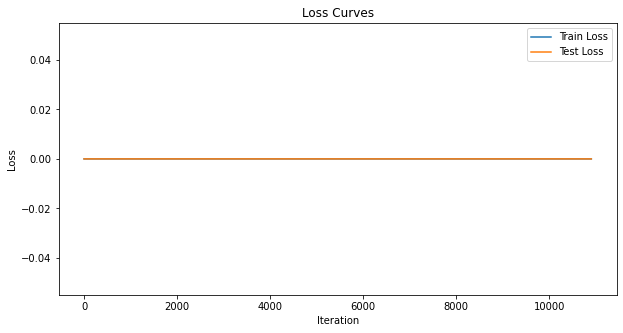

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()